# Fantasy Premier League 2021/2022 Season Analysis:

**This notebook covers how to access the Fantasy Premier League API, build a dataframe, and analyze  the data using Jupyter, Python, Pandas, and Matplotlib.**

**About the game**: Each FPL manager is given a starting budget of £100 million and must pick a total of 15 players: two goalkeepers, five defenders, five midfielders and three forwards. You are limited to a maximum of three players from each Premier League team. Players in your team score points based on real-life performances with the biggest contributors being goals, assists and cleansheets.

**Analysis Limits**: The data used in this notebook includes all season totals at the end of Gameweek 38 of the 2021/2022 season. This is more of a season overview analysis than a week-to-week analysis, therefore, form and fixtures were not accounted for. The prices used are provided by the FPL API and have already changed to 2022/2023 prices. I have created a 'price range' category to make the analysis more accurate as price changes generally happen within their price range.

## 4. Machine Learning

### Multiple Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
#Load data
df1 = pd.read_csv('data/fpl_data_t.csv')
df2 = pd.read_csv('players.csv')

new_df = df1.append(df2)


In [3]:
#Consider only players who have played atleast 40% of total possible minutes

filt = (new_df['minutes'] > 38 * 0.4 * 90)
slim_df = new_df.loc[filt]

In [4]:
#Select features
features =  ['points_per_game', 'influence', 'ict_index', 'minutes']
target = 'total_points'

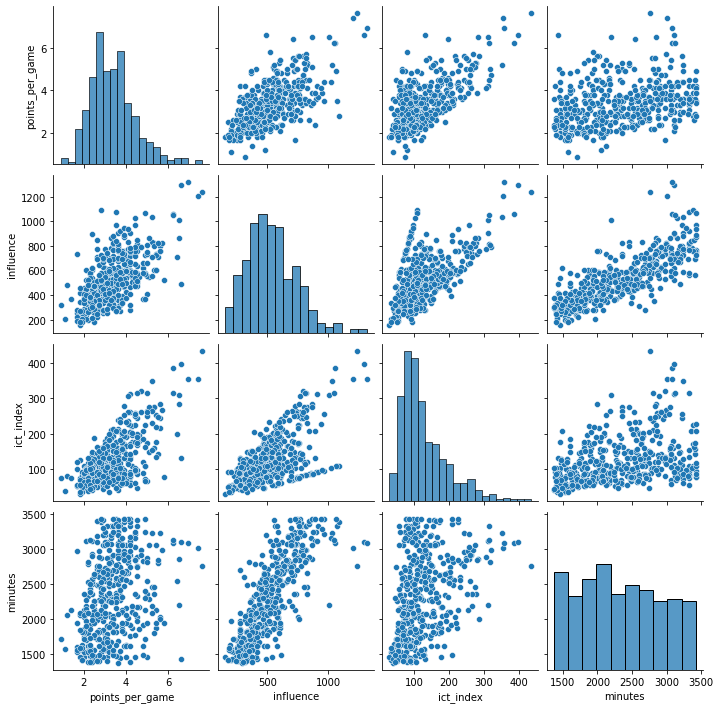

In [5]:
#Check multicollinearity
sns.pairplot(slim_df.reset_index()[features])

In [6]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

#Create target and feature
X = slim_df[features]
y = slim_df[target]

#Split dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Fit model
mlr = linear_model.LinearRegression()
mlr.fit(x_train,y_train)

#Make estimate
Yhat = mlr.predict(x_test)

In [7]:
from sklearn import metrics

#Evaluation metrics
meanAbErr = metrics.mean_absolute_error(y_test, Yhat)
meanSqErr = metrics.mean_squared_error(y_test, Yhat)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, Yhat))

print('R squared:{:.2f}'.format(mlr.score(X, y)))
print('Mean Absolute Error:', meanAbErr)
print('Mean Squared Error:', meanSqErr)
print('Root Mean Squared Error:', rootMeanSqErr)
print('Normalized RMSE:', rootMeanSqErr / (y.max() - y.min()))

# The coefficient and intercept
intercept = mlr.intercept_
coef = mlr.coef_

print('Intercept:', intercept)
print ('Coefficients:', coef)

R squared:0.95
Mean Absolute Error: 7.267685923022662
Mean Squared Error: 83.4164291990222
Root Mean Squared Error: 9.13325950573081
Normalized RMSE: 0.037585430064735845
Intercept: -52.05178530483013
Coefficients: [2.32034862e+01 7.09900706e-03 1.32478292e-01 2.30998152e-02]


In [8]:
#Create players dictionary
players_dict = dict(zip(df1['web_name'], df1[features].values))

In [9]:
#Create points predictor helper function
def predict_player_points(w, b, name):
    stats = players_dict[name]
    stats = list(stats) 
    estimate = round(np.dot(w, stats) + b)
    if estimate < 0:
        estimate = 0
    return estimate

In [10]:
#Add predicted points column
df1['predicted_points'] = df1['web_name'].apply(lambda x: predict_player_points(coef, intercept, x))

#Create error column
df1['error'] = df1['total_points'] - df1['predicted_points']

<AxesSubplot:xlabel='error', ylabel='Count'>

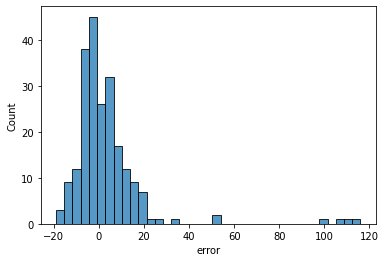

In [20]:
#View distribution of error
filt = (df1['minutes'] > 38 * 0.4 * 90)
slim_df1 = df1.loc[filt]
sns.histplot(data=slim_df1, x='error')

In [13]:
g = df1[df1['element_type'] == 1].sort_values(by='predicted_points', ascending=False).head(2)
d = df1[df1['element_type'] == 2].sort_values(by='predicted_points', ascending=False).head(5)
m = df1[df1['element_type'] == 3].sort_values(by='predicted_points', ascending=False).head(5)
f = df1[df1['element_type'] == 4].sort_values(by='predicted_points', ascending=False).head(3)

predicted_df = pd.concat([g,d,m,f])
predicted_df[['web_name', 'total_points', 'predicted_points']]

,web_name,total_points,predicted_points
293,Alisson,176,151
447,Lloris,158,140
297,Alexander-Arnold,208,208
321,Cancelo,201,190
296,Robertson,186,186
292,Van Dijk,183,167
288,Matip,170,164
295,Salah,265,254
450,Son,258,245
317,De Bruyne,196,198


In [14]:
g = df1[df1['element_type'] == 1].sort_values(by='total_points', ascending=False).head(2)
d = df1[df1['element_type'] == 2].sort_values(by='total_points', ascending=False).head(5)
m = df1[df1['element_type'] == 3].sort_values(by='total_points', ascending=False).head(5)
f = df1[df1['element_type'] == 4].sort_values(by='total_points', ascending=False).head(3)

predicted_df = pd.concat([g,d,m,f])
predicted_df[['web_name', 'total_points', 'predicted_points']]

,web_name,total_points,predicted_points
293,Alisson,176,151
447,Lloris,158,140
297,Alexander-Arnold,208,208
321,Cancelo,201,190
296,Robertson,186,186
292,Van Dijk,183,167
288,Matip,170,164
295,Salah,265,254
450,Son,258,245
488,Bowen,206,190
